In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import os.path as osp
from joblib import Parallel, delayed
from itertools import product, combinations
from skimage import exposure

In [1]:
# use this to keep the cells wider, very nice on wide screens, set the percentage as you like it
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
from pandas.io.common import _NA_VALUES
na_values = _NA_VALUES - {'NULL', 'null', 'nan', 'NaN'}

animes = pd.read_csv('anime_cleaned.csv')
users = pd.read_csv('users_cleaned.csv', na_values=na_values, keep_default_na=False)
animelists = pd.read_csv('animelists_cleaned.csv', na_values=na_values, keep_default_na=False)

In [6]:
users['birth_date'] = pd.to_datetime(users['birth_date'])
users['last_online'] = pd.to_datetime(users['last_online'])
users['join_date'] = pd.to_datetime(users['join_date'])
animelists['my_last_updated'] = pd.to_datetime(animelists['my_last_updated'])
# renaming possibly array-like columns to end with -s
animes = animes.rename(columns={'genre': 'genres', 'studio': 'studios'})

In [7]:
# setting index for primary identifiers
animes = animes.set_index('anime_id')
users = users.set_index('username')

In [8]:
#users['age'] = 2019 - users['birth_date'].dt.year   # fix this to be more robust and precise
users['age'] = (pd.Timestamp.now() - users['birth_date']).dt.days // 365

In [9]:
animes.head()

,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,...,broadcast,related,producer,licensor,studios,genres,opening_theme,ending_theme,duration_min,aired_from_year
anime_id,,,,,,,,,,,,,,,,,,,,,
11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,False,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,False,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,False,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,False,...,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0


In [10]:
animelists.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,episodes,status
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,0.0,0,2013-03-03 10:52:53,NaN,0,Currently Airing
1,RedvelvetDaisuki,21,0,0000-00-00,0000-00-00,0,3,0.0,0,2012-12-14 10:25:01,NaN,0,Currently Airing
2,Damonashu,21,418,0000-00-00,0000-00-00,10,1,0.0,0,2009-09-30 07:39:05,NaN,0,Currently Airing
3,bskai,21,75,0000-00-00,0000-00-00,8,1,0.0,0,2010-06-15 21:31:23,NaN,0,Currently Airing
4,Slimak,21,834,0000-00-00,0000-00-00,10,1,0.0,0,2018-05-01 12:05:21,NaN,0,Currently Airing


In [11]:
users.head()

,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,stats_mean_score,stats_rewatched,stats_episodes,last_online,age
username,,,,,,,,,,,,,,,,,
karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,7.43,0.0,3391.0,2013-05-05 14:38:12,29
RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,NaN,2012-12-13,6.78,80.0,7094.0,2018-05-04 14:59:17,25
Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,6.15,6.0,4936.0,2017-07-10 06:52:54,28
bskai,228342,25,414,2,5,11,167.16,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,8.27,1.0,10081.0,2014-05-12 06:42:27,29
terune_uzumaki,327311,5,5,0,0,0,15.20,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,9.70,6.0,920.0,2011-11-26 11:15:25,21


### What is the composition of active users when grouped by gender/age? In comparison with all users?
Active users are users with some ratings in last 3 months

Percentage of males + female + non-binary = 100%

#### Grouped by gender

In [12]:
# newest update date, reflects time of data gathering
now = animelists['my_last_updated'].max()
now

Timestamp('2018-05-22 07:49:06')

In [13]:
from dateutil.relativedelta import relativedelta
last_update = animelists.groupby('username')['my_last_updated'].max()
is_active = last_update > (now - relativedelta(months=3))
active_users = last_update[is_active].index

In [21]:
(users['gender'].value_counts() / users['gender'].count())

Male          0.654217
Female        0.340625
Non-Binary    0.005158
Name: gender, dtype: float64

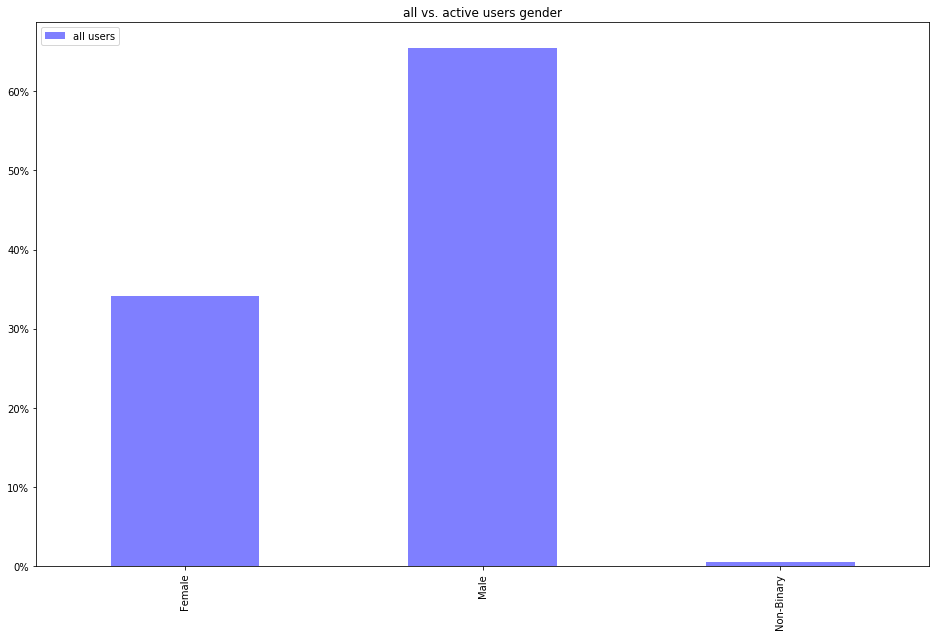

In [27]:
(users['gender'].value_counts() / users['gender'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users gender', color='blue', alpha=0.5, label='all users')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)

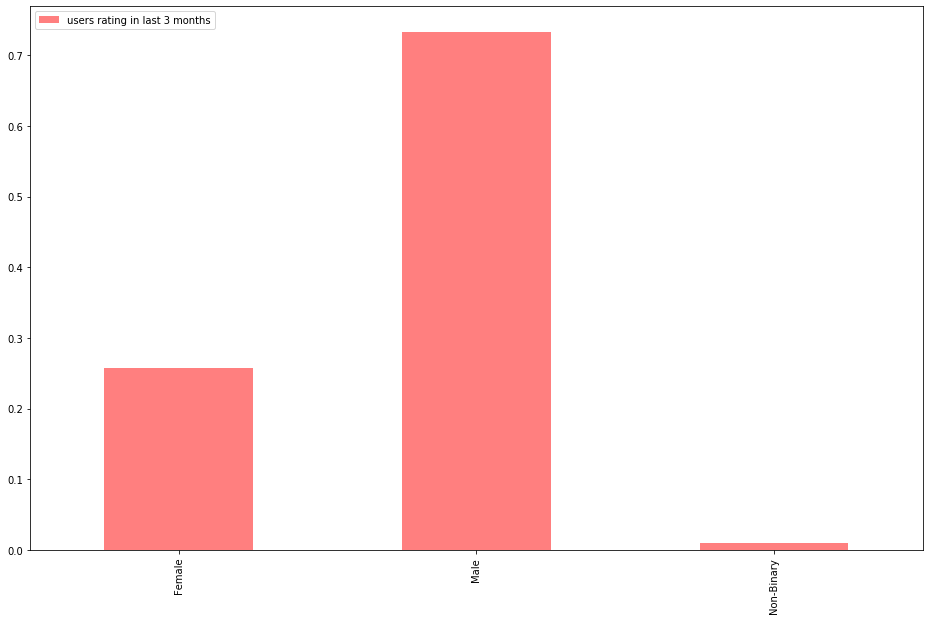

In [28]:
(users.loc[active_users]['gender'].value_counts() / users.loc[active_users]['gender'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.legend(loc=2)

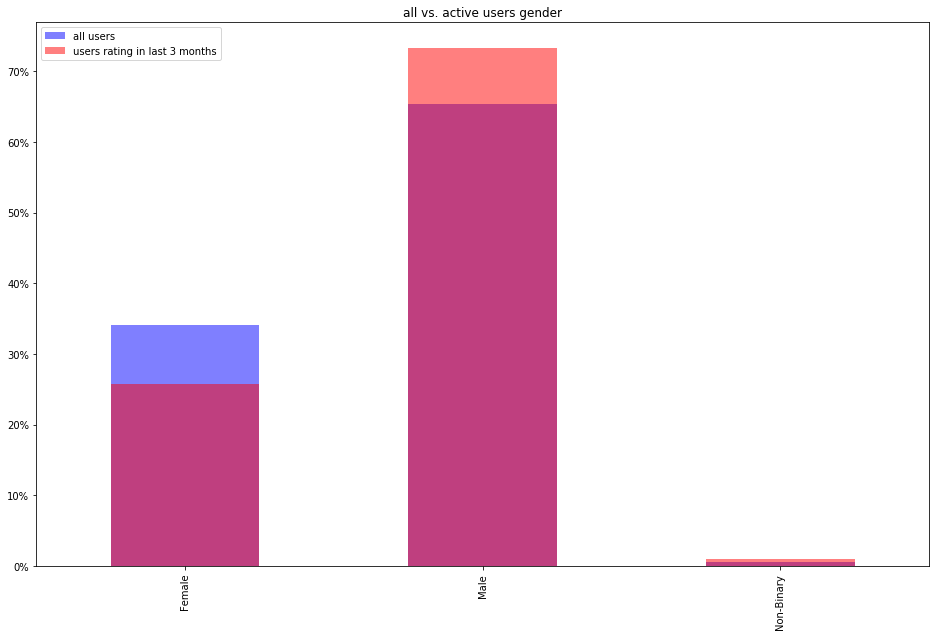

In [29]:
(users['gender'].value_counts() / users['gender'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users gender', color='blue', alpha=0.5, label='all users')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)
(users.loc[active_users]['gender'].value_counts() / users.loc[active_users]['gender'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.legend(loc=2)

Red and blue mixed together give pink. From the above graph, we see that the percentage of active male and non-binary users(those who have rated animes in the last 3 months) with respect to the total number of active users is larger than the percentage of all males and non-binary users with respect to everyone(all genders). In order words, it is easier to find an active male/non-binary user when users are categorised by gender.

#### Grouped by age

In [35]:
users['age'] = 2019 - users['birth_date'].dt.year

In [36]:
users = users[(users['age'] >= 10) & (users['age'] <= 60)]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


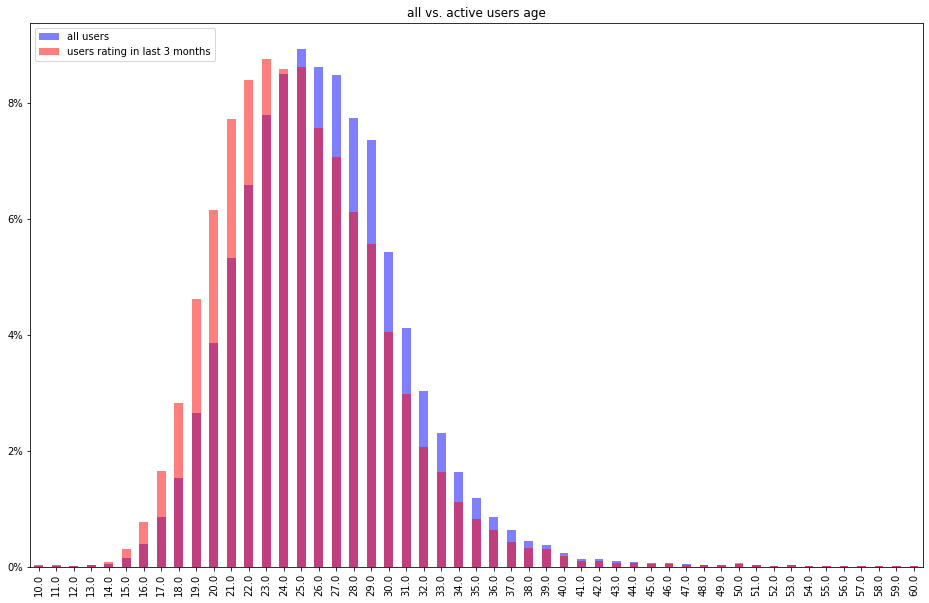

In [37]:
(users['age'].value_counts() / users['age'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users age', color='blue', alpha=0.5, label='all users')
(users.loc[active_users]['age'].value_counts() / users.loc[active_users]['age'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)

From the above graph, we can see that younger people are generally more active in rating anime than older people.

### Explore the user composition for watched anime per genre by age and gender

In [40]:
animes['genres'].fillna('', inplace=True)
genres_arr = animes['genres'].str.replace(' ', '').str.split(',', expand=True).stack().reset_index(drop=True, level=1).to_frame(name='genre')
genres_arr = genres_arr[genres_arr['genre'] != '']
animes_genres = pd.merge(animes, genres_arr, how='inner', left_index=True, right_index=True)
genres = genres_arr['genre'].unique()

In [41]:
# semantics of my_status column
status = {
    'watching': 1,
    'completed': 2,
    'on hold': 3,
    'dropped': 4,
    'plan to watch': 6,
}

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

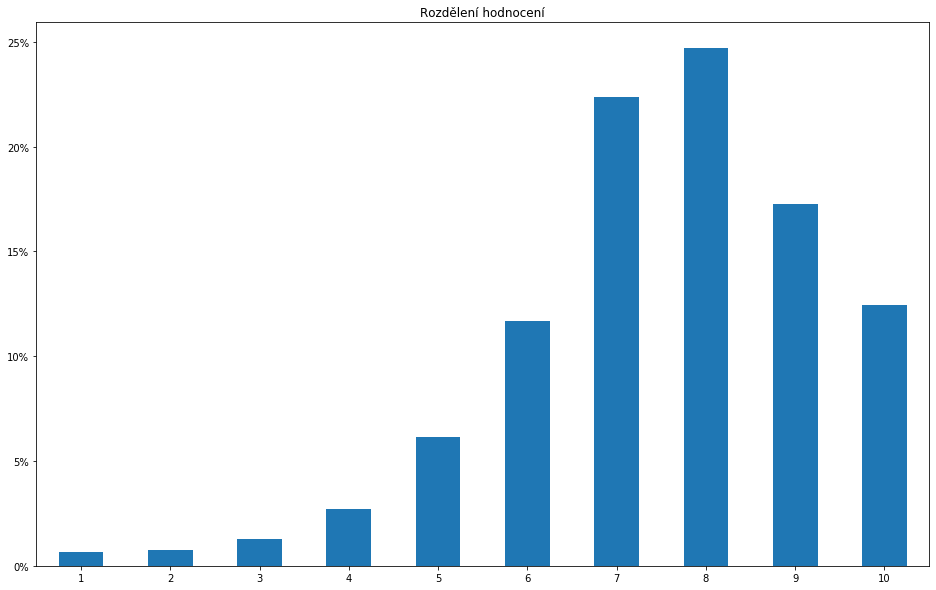

In [43]:
#showing score distribution
scores = animelists[animelists['my_score'] != 0]['my_score'].value_counts()
(scores / scores.sum()).sort_index().plot(kind='bar', figsize=(16, 10), title='Score distribution')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xticks(rotation=0)

In [46]:
completed = animelists['my_status'] == status['completed']
dropped = animelists['my_status'] == status['dropped']
rated = animelists['my_score'] != 0
users['all_completed'] = animelists[completed].groupby('username')['anime_id'].count() # total number of anime that a user 
users['all_dropped'] = animelists[dropped].groupby('username')['anime_id'].count()
users['all_meanscore'] = animelists[completed & rated].groupby('username')['my_score'].mean()
users['all_rated'] = animelists[completed & rated].groupby('username')['anime_id'].count()

([<matplotlib.axis.XTick at 0x3162ab790>,
 <a list of 11 Text xticklabel objects>)

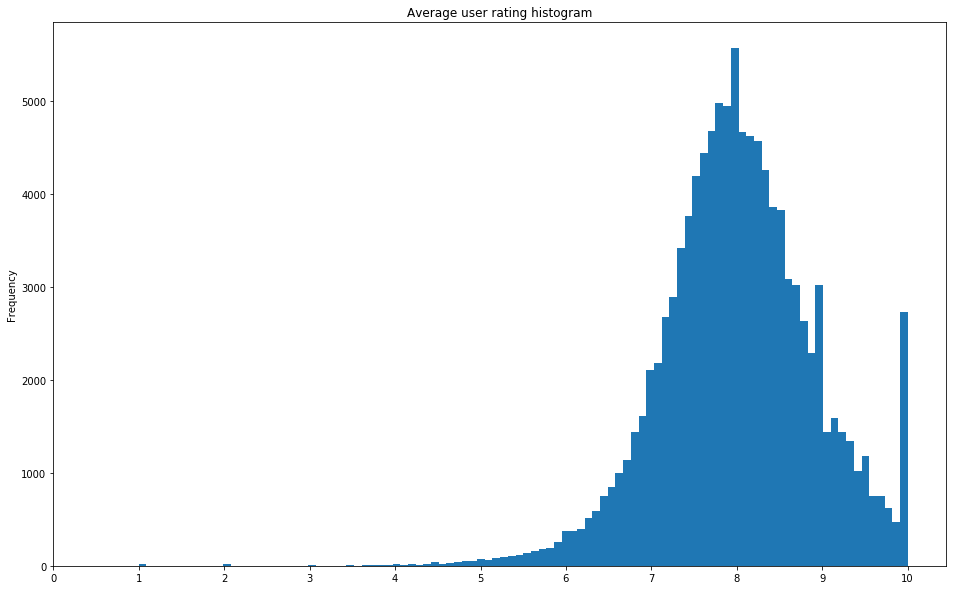

In [47]:
users['all_meanscore'] = animelists[completed & rated].groupby('username')['my_score'].mean()
users['all_meanscore'].plot(kind='hist', bins=100, figsize=(16, 10), title='Average user rating histogram')
plt.xticks(range(11), rotation=0)

Generally people who rate will tend to give higher scores than lower scores. It makes sense since most people are usually lazy and will not bother to rate watched anime. Only those who were deeply (negatively/positively) impacted by the anime will tend to rate it. And usually you will have read reviews/watched teasers before watching anime so you will most likely end up liking the anime you watch. This is especially true for anime lovers, who have a very clear understanding of their tastes and preferences.

In [49]:
print('total users:', users['all_meanscore'].count())
print('users with mean score 10:', (users['all_meanscore'] == 10).sum())

total users: 109881
users with mean score 10: 2446


### Relationship between users and genres

In [60]:
def filter_by_genre(animelists, genre):
    print(genre)
    return genre, animelists[animelists['anime_id'].isin(genres_arr[genres_arr['genre'] == genre].index)]

res_lists = Parallel(n_jobs=16, backend='threading')(delayed(filter_by_genre)(animelists, genre) for genre in genres_arr['genre'].unique())
animelists_genres = {key: val for key, val in res_lists}

Comedy
Supernatural
Romance
Shounen
Parody
School
Magic
Shoujo
Drama
Fantasy
Kids
Action
MusicSliceofLife
JoseiHarem


ShounenAi
Adventure
SuperPower
Sci-FiEcchi

SeinenMartialArts
Game

Sports
Demons
Historical
Horror
MysteryPsychologicalVampire


Mecha
Military
Space
Samurai
Thriller
Hentai
Yaoi
Police
ShoujoAi
Cars
Dementia
Yuri


In [63]:
def calculate_genre_pairs(genre1, genre2):
    animelists_genre1 = animelists_genres[genre1]
    animelists_genre2 = animelists_genres[genre2]
    animelists_genre = pd.concat([animelists_genre1, animelists_genre2]).drop_duplicates(['username', 'anime_id']).reset_index(drop=True) # merging those two
    genres_name = genre1 + '_' + genre2
    print('processing genres pair: ', genres_name)
    completed = animelists_genre['my_status'] == status['completed']
    users['pair_completed_'+genres_name] = animelists_genre[completed].groupby('username')['anime_id'].count()
    dropped = animelists_genre['my_status'] == status['dropped']
    users['pair_dropped_'+genres_name] = animelists_genre[dropped].groupby('username')['anime_id'].count()
    rated = animelists_genre['my_score'] != 0
    users['pair_meanscore_'+genres_name] = animelists_genre[completed & rated].groupby('username')['my_score'].mean()
    # good score is 9 or higher
    rated8 = animelists_genre['my_score'] > 8
    users['pair_scoreabove8_'+genres_name] = animelists_genre[completed & rated8].groupby('username')['my_score'].count()
    # score is 10
    rated9 = animelists_genre['my_score'] > 9
    users['pair_scoreabove9_'+genres_name] = animelists_genre[completed & rated9].groupby('username')['my_score'].count()
    
if osp.exists('users_calculated.csv'):
    users = pd.read_csv('users_calculated.csv', na_values=na_values, keep_default_na=False)
    users = users.set_index('username')
else:
    # handcrafted features
    for genre, animelists_genre in animelists_genres.items():
        print('processing genre: ', genre)
        completed = animelists_genre['my_status'] == status['completed']
        users['completed_'+genre] = animelists_genre[completed].groupby('username')['anime_id'].count()
        dropped = animelists_genre['my_status'] == status['dropped']
        users['dropped_'+genre] = animelists_genre[dropped].groupby('username')['anime_id'].count()
        rated = animelists_genre['my_score'] != 0
        users['meanscore_'+genre] = animelists_genre[completed & rated].groupby('username')['my_score'].mean()
        # good score is 9 or higher
        rated8 = animelists_genre['my_score'] > 8
        users['scoreabove8_'+genre] = animelists_genre[completed & rated8].groupby('username')['my_score'].count()
        # score is 10
        rated9 = animelists_genre['my_score'] > 9
        users['scoreabove9_'+genre] = animelists_genre[completed & rated9].groupby('username')['my_score'].count()

    # handcrafted features for OR of all pairs
    # without parallelization, it's annoyingly slow
    #Parallel(n_jobs=8, backend='threading')(delayed(calculate_genre_pairs)(genre1, genre2) for genre1, genre2 in combinations(animelists_genres.keys(), 2))  # generates all pairs
    for genre1, genre2 in combinations(animelists_genres.keys(), 2):
        calculate_genre_pairs(genre1, genre2)

processing genre:  Comedy
processing genre:  Supernatural
processing genre:  Romance
processing genre:  Shounen
processing genre:  Parody
processing genre:  School
processing genre:  Magic
processing genre:  Shoujo
processing genre:  Drama
processing genre:  Fantasy
processing genre:  Kids
processing genre:  Action
processing genre:  Music
processing genre:  SliceofLife
processing genre:  Josei
processing genre:  Harem
processing genre:  ShounenAi
processing genre:  Adventure
processing genre:  SuperPower
processing genre:  Sci-Fi
processing genre:  Ecchi
processing genre:  Seinen
processing genre:  MartialArts
processing genre:  Game
processing genre:  Sports
processing genre:  Demons
processing genre:  Historical
processing genre:  Horror
processing genre:  Mystery
processing genre:  Psychological
processing genre:  Vampire
processing genre:  Mecha
processing genre:  Military
processing genre:  Space
processing genre:  Samurai
processing genre:  Thriller
processing genre:  Hentai
pro

processing genres pair:  Parody_SliceofLife
processing genres pair:  Parody_Josei
processing genres pair:  Parody_Harem
processing genres pair:  Parody_ShounenAi
processing genres pair:  Parody_Adventure
processing genres pair:  Parody_SuperPower
processing genres pair:  Parody_Sci-Fi
processing genres pair:  Parody_Ecchi
processing genres pair:  Parody_Seinen
processing genres pair:  Parody_MartialArts
processing genres pair:  Parody_Game
processing genres pair:  Parody_Sports
processing genres pair:  Parody_Demons
processing genres pair:  Parody_Historical
processing genres pair:  Parody_Horror
processing genres pair:  Parody_Mystery
processing genres pair:  Parody_Psychological
processing genres pair:  Parody_Vampire
processing genres pair:  Parody_Mecha
processing genres pair:  Parody_Military
processing genres pair:  Parody_Space
processing genres pair:  Parody_Samurai
processing genres pair:  Parody_Thriller
processing genres pair:  Parody_Hentai
processing genres pair:  Parody_Y

processing genres pair:  Kids_Josei
processing genres pair:  Kids_Harem
processing genres pair:  Kids_ShounenAi
processing genres pair:  Kids_Adventure
processing genres pair:  Kids_SuperPower
processing genres pair:  Kids_Sci-Fi
processing genres pair:  Kids_Ecchi
processing genres pair:  Kids_Seinen
processing genres pair:  Kids_MartialArts
processing genres pair:  Kids_Game
processing genres pair:  Kids_Sports
processing genres pair:  Kids_Demons
processing genres pair:  Kids_Historical
processing genres pair:  Kids_Horror
processing genres pair:  Kids_Mystery
processing genres pair:  Kids_Psychological
processing genres pair:  Kids_Vampire
processing genres pair:  Kids_Mecha
processing genres pair:  Kids_Military
processing genres pair:  Kids_Space
processing genres pair:  Kids_Samurai
processing genres pair:  Kids_Thriller
processing genres pair:  Kids_Hentai
processing genres pair:  Kids_Yaoi
processing genres pair:  Kids_ShoujoAi
processing genres pair:  Kids_Police
processing g

processing genres pair:  Adventure_MartialArts
processing genres pair:  Adventure_Game
processing genres pair:  Adventure_Sports
processing genres pair:  Adventure_Demons
processing genres pair:  Adventure_Historical
processing genres pair:  Adventure_Horror
processing genres pair:  Adventure_Mystery
processing genres pair:  Adventure_Psychological
processing genres pair:  Adventure_Vampire
processing genres pair:  Adventure_Mecha
processing genres pair:  Adventure_Military
processing genres pair:  Adventure_Space
processing genres pair:  Adventure_Samurai
processing genres pair:  Adventure_Thriller
processing genres pair:  Adventure_Hentai
processing genres pair:  Adventure_Yaoi
processing genres pair:  Adventure_ShoujoAi
processing genres pair:  Adventure_Police
processing genres pair:  Adventure_Cars
processing genres pair:  Adventure_Dementia
processing genres pair:  Adventure_Yuri
processing genres pair:  SuperPower_Sci-Fi
processing genres pair:  SuperPower_Ecchi
processing genre

processing genres pair:  Historical_Yuri
processing genres pair:  Horror_Mystery
processing genres pair:  Horror_Psychological
processing genres pair:  Horror_Vampire
processing genres pair:  Horror_Mecha
processing genres pair:  Horror_Military
processing genres pair:  Horror_Space
processing genres pair:  Horror_Samurai
processing genres pair:  Horror_Thriller
processing genres pair:  Horror_Hentai
processing genres pair:  Horror_Yaoi
processing genres pair:  Horror_ShoujoAi
processing genres pair:  Horror_Police
processing genres pair:  Horror_Cars
processing genres pair:  Horror_Dementia
processing genres pair:  Horror_Yuri
processing genres pair:  Mystery_Psychological
processing genres pair:  Mystery_Vampire
processing genres pair:  Mystery_Mecha
processing genres pair:  Mystery_Military
processing genres pair:  Mystery_Space
processing genres pair:  Mystery_Samurai
processing genres pair:  Mystery_Thriller
processing genres pair:  Mystery_Hentai
processing genres pair:  Mystery_

In [64]:
completed_columns = sorted(['completed_'+x for x in genres if x != ''])
above8_columns = sorted(['scoreabove8_'+x for x in genres if x != ''])
above9_columns = sorted(['scoreabove9_'+x for x in genres if x != ''])
mean_columns = sorted(['meanscore_'+x for x in genres if x != ''])

In [80]:
users[completed_columns]

,completed_Action,completed_Adventure,completed_Cars,completed_Comedy,completed_Dementia,completed_Demons,completed_Drama,completed_Ecchi,completed_Fantasy,completed_Game,...,completed_ShounenAi,completed_SliceofLife,completed_Space,completed_Sports,completed_SuperPower,completed_Supernatural,completed_Thriller,completed_Vampire,completed_Yaoi,completed_Yuri
username,,,,,,,,,,,,,,,,,,,,,
karthiga,7.0,5.0,0.0,40.0,0.0,4.0,22.0,4.0,10.0,2.0,...,4.0,10.0,0.0,2.0,2.0,8.0,0.0,0.0,0.0,0.0
RedvelvetDaisuki,118.0,64.0,0.0,186.0,11.0,25.0,136.0,25.0,77.0,16.0,...,14.0,72.0,1.0,16.0,27.0,106.0,19.0,12.0,8.0,0.0
Damonashu,103.0,68.0,0.0,90.0,6.0,6.0,75.0,12.0,53.0,4.0,...,0.0,18.0,8.0,6.0,32.0,46.0,12.0,11.0,0.0,0.0
bskai,130.0,79.0,0.0,242.0,5.0,9.0,144.0,82.0,106.0,4.0,...,0.0,64.0,10.0,11.0,37.0,67.0,3.0,10.0,0.0,0.0
terune_uzumaki,0.0,1.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
isoann,66.0,14.0,0.0,130.0,2.0,10.0,62.0,35.0,28.0,3.0,...,0.0,51.0,0.0,6.0,19.0,73.0,11.0,7.0,0.0,0.0
bumcakee,23.0,15.0,0.0,69.0,2.0,6.0,40.0,4.0,22.0,2.0,...,6.0,29.0,1.0,3.0,4.0,38.0,4.0,3.0,0.0,0.0
Scarlet95,61.0,20.0,0.0,46.0,1.0,5.0,31.0,9.0,37.0,4.0,...,1.0,11.0,0.0,7.0,9.0,41.0,4.0,10.0,0.0,0.0


In [79]:
users['all_completed'] 

username
karthiga             49.0
RedvelvetDaisuki    396.0
Damonashu           195.0
bskai               414.0
terune_uzumaki        5.0
                    ...  
isoann              213.0
bumcakee            116.0
Scarlet95           103.0
Torasori            239.0
HMicca               73.0
Name: all_completed, Length: 112971, dtype: float64

In [65]:
users[completed_columns] = users[completed_columns].fillna(0)  # without this, NaN values are ommited from mean calculation, which messes up data a lot
# semantically, NaN is zero, because it means that user has no completed anime of that genre
users_completed = users[completed_columns].div(users['all_completed'], axis=0).fillna(0) # Get Floating division of dataframe and other, element-wise (binary operator truediv).
users_ages_completed = users_completed.join(users['age'])
ages_genres = users_ages_completed.groupby('age').mean()
users_genders_completed = users_completed.join(users['gender'])
genders_genres = users_genders_completed.groupby('gender').mean()

users[above8_columns] = users[above8_columns].fillna(0)
users[above9_columns] = users[above9_columns].fillna(0)
users[mean_columns] = users[mean_columns].fillna(0)

In [66]:
completed_columns_with_pairs = sorted([x for x in users.columns if 'pair_completed_' in x or 'completed_' in x])
# display(completed_columns_with_pairs)

users[completed_columns_with_pairs] = users[completed_columns_with_pairs].fillna(0)
# semantically, NaN is zero, because it means that user has no completed anime of that genre
users_completed_pairs = users[completed_columns_with_pairs].div(users['all_completed'], axis=0).fillna(0)
users_ages_completed_pairs = users_completed_pairs.join(users['age'])
ages_genres_pairs = users_ages_completed_pairs.groupby('age').mean()
users_genders_completed_pairs = users_completed_pairs.join(users['gender'])
genders_genres_pairs = users_genders_completed_pairs.groupby('gender').mean()

In [74]:
def cmap_to_array(cmap, N=256):
    """
    Return a Nx3 array of RGB values generated from a colormap.
    """
    return cmap(np.linspace(0, 1, N))[:, :3]  # remove alpha column


def equalize_colormap_base(cmap, data):
    if isinstance(data, (pd.DataFrame, pd.Series)):
        data = data.values
    data = data[~np.isnan(data)].flatten()
    assert np.issubdtype(data.dtype, np.floating), 'Data must be floating, otherwise it does not work'

    cdf, bins = exposure.cumulative_distribution(data, nbins=256)
    # Using it for highly non-uniform data will cause high information loss for extreme values
    # So we do only half equalization, equalizing with histogram averaged with uniform histogram
    # and now the same for uniform distribution of same size
    cdf_u, bins_u = exposure.cumulative_distribution(np.linspace(data.min(), data.max(), data.shape[0]), nbins=256)
    cdf = (cdf + cdf_u) / 2
    '''
    Re-map a colormap according to a cumulative distribution. This is used to 
    perform histogram equalization of an image by changing the colormap 
    instead of the image. *This is not strickly speaking the equalization of the 
    colormap itself*.
    The cdf and bins should be calculated from an input image, as if carrying out
    the histogram equalization of that image. In effect, the cdf becomes integrated  
    to the colormap as a mapping function by redistributing the indices of the
    input colormap.
    Parameters
    ----------
    cmap : string or colormap object
        Input colormap to remap.
    bins : array
        Centers of bins.
    cdf : array
        Values of cumulative distribution function.
    '''

    # first retrieve the color table (lists of RGB values) behind the input colormap
    if cmap in mpl.cm.cmap_d:  # matplotlib colormaps + plus the new ones (viridis, inferno, etc.)
        cmList = cmap_to_array(plt.cm.cmap_d[cmap])
    else:
        try:
            # in case cmap is a colormap object
            cmList = cmap_to_array(cmap)
        except:
            raise ValueError('Colormap {} has not been recognised'.format(cmap))

    # normalize the input bins to interval (0,1)
    bins_norm = (bins - bins.min()) / np.float(bins.max() - bins.min())

    # calculate new indices by applying the cdf as a function on the old indices
    # which are initially regularly spaced.
    old_indices = np.linspace(0, 1, len(cmList))
    new_indices = np.interp(old_indices, cdf, bins_norm)

    # make sure indices start with 0 and end with 1
    new_indices[0] = 0.0
    new_indices[-1] = 1.0

    return new_indices, cmList


def equalize_colormap_plotly(cmap, data):
    new_indices, cmList = equalize_colormap_base(cmap, data)

    carr = []
    for i, n in enumerate(new_indices):
        r, g, b = (cmList[i] * 256).astype(int)
        rgb_str = f'rgb({r}, {g}, {b})'
        carr.append([n, rgb_str])

    return carr


def equalize_colormap(cmap, data, name='EqualizedMap'):
    new_indices, cmList = equalize_colormap_base(cmap, data)
    # remap the color table
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, n in enumerate(new_indices):
        r1, g1, b1 = cmList[i]
        cdict['red'].append([n, r1, r1])
        cdict['green'].append([n, g1, g1])
        cdict['blue'].append([n, b1, b1])

    return mpl.colors.LinearSegmentedColormap(name, cdict)

Text(0.5, 1, 'percentage of people in an age group who have completed watching animes of a certain genre')

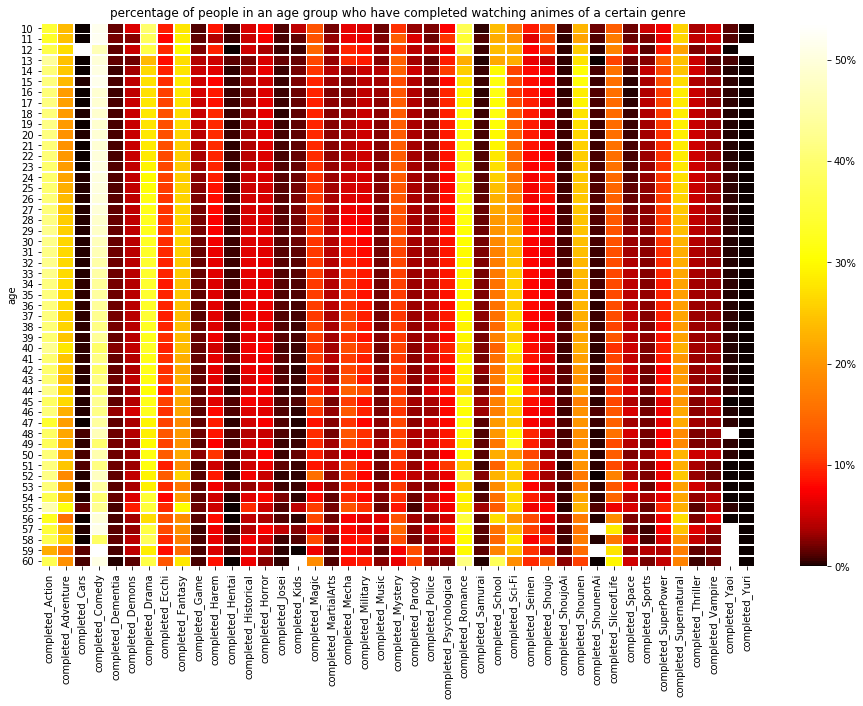

In [94]:
f, ax = plt.subplots(figsize=(16, 10))
data = ages_genres * 100 # the percentage of people in an age group who have completed watching animes of a certain genre
cmap = equalize_colormap(plt.cm.hot, data)
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data, mask=mask, cmap=cmap, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.title('percentage of people in an age group who have completed watching animes of a certain genre')

In [93]:
ages_genres*100

,completed_Action,completed_Adventure,completed_Cars,completed_Comedy,completed_Dementia,completed_Demons,completed_Drama,completed_Ecchi,completed_Fantasy,completed_Game,...,completed_ShounenAi,completed_SliceofLife,completed_Space,completed_Sports,completed_SuperPower,completed_Supernatural,completed_Thriller,completed_Vampire,completed_Yaoi,completed_Yuri
age,,,,,,,,,,,,,,,,,,,,,
10,34.648750,23.839293,0.131137,51.562629,1.706208,5.928911,39.874795,9.085621,27.700101,1.141623,...,2.091733,13.568878,1.913843,5.114336,7.140913,25.908203,3.695570,5.705421,1.296794,0.048301
11,33.491359,24.362589,0.173601,52.164287,2.303914,2.719540,38.329108,7.921160,28.811769,1.620427,...,1.219177,16.899026,1.757938,2.467030,6.589778,26.294783,4.805113,5.269288,1.064673,0.012287
12,36.551065,26.905160,0.000000,46.502799,1.540159,4.923495,36.452063,9.822958,30.122050,2.504171,...,0.478167,18.000286,3.948911,1.273114,8.837969,21.248291,2.390514,3.926217,0.118862,0.000000
13,43.662672,24.366761,0.132228,49.643474,1.669908,2.020718,23.675889,8.184846,26.889506,4.039691,...,0.105607,11.161554,1.704263,2.556787,13.316537,24.460289,4.828602,1.282600,0.952098,0.034619
14,40.816383,24.986172,0.013226,50.620421,0.802856,3.472921,26.557068,9.286383,27.493746,4.876915,...,1.034762,15.837948,1.046054,4.706642,11.353630,24.694137,5.287608,2.248157,0.365865,0.033331
15,41.266361,23.545522,0.222789,51.419160,0.926989,4.467962,27.264975,9.962423,28.159011,5.105414,...,0.730809,15.413080,0.600956,3.598315,11.833318,26.931866,3.801721,2.944199,0.495785,0.039172
16,40.756246,20.729189,0.131798,49.233363,0.790124,4.522576,27.415631,11.039747,27.919159,5.466114,...,1.060222,15.442967,0.365292,3.958240,10.820556,28.591663,4.854966,2.872198,0.594415,0.066693
17,41.364066,20.968121,0.171913,49.214563,0.868387,4.889450,28.035820,11.142837,27.615043,4.975698,...,0.958584,15.058735,0.574654,4.236581,11.308394,28.407485,4.830994,2.857492,0.495338,0.076733
18,41.069408,20.367927,0.212188,48.843071,0.871905,4.852589,28.079097,12.163010,26.899787,4.970889,...,0.921665,15.046493,0.640846,3.881632,10.755762,28.588445,4.759208,3.000504,0.418563,0.059639


In general, comedy, drama, action and romance are genres that people of all ages enjoy watching. The least watched genres are yaoi,yuri, ShounenAi and cars. The data may not accurately paint reality since less people are willing to admit to watching these more graphic and explicit genres. Thus they binge on these genres, but not keep a record of their watching history.  

There seems to be a relation between the interests and concerns of each age group and the genres watched. School related genre are most popular amongst teens and university students (ages 14-21). People in their young 20's are more interested in the supernatural than older people, and adventure is particularly popular amongst the mid 20's to mid 30's. 

Text(0.5, 1, 'histograms normed per genre')

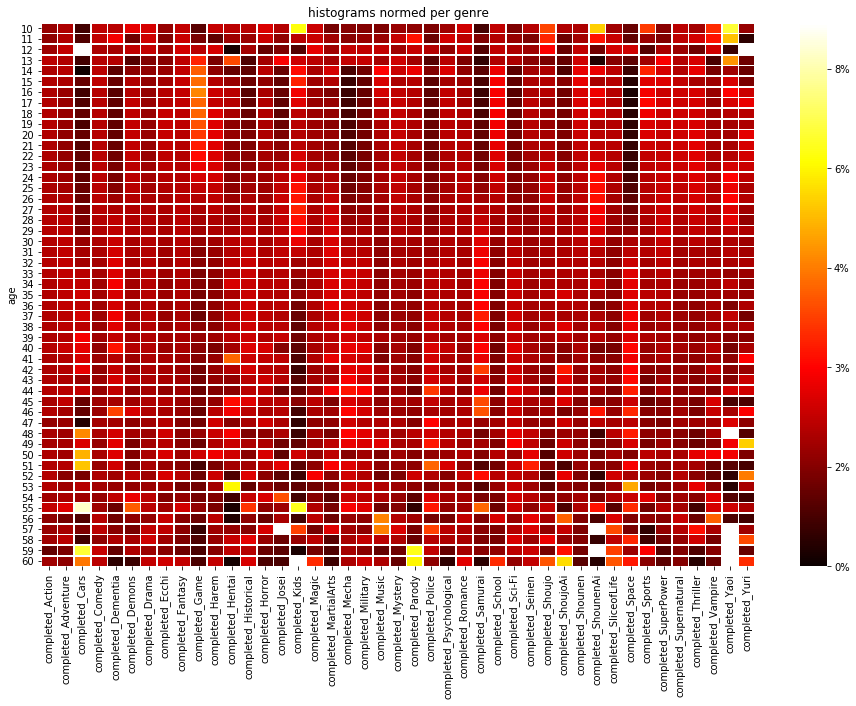

In [95]:
f, ax = plt.subplots(figsize=(16, 10))
data = ages_genres.div(ages_genres.sum(axis=0), axis=1) * 100
#data = ages_genres * 100
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data, mask=mask, cmap=plt.cm.hot, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.title('histograms normed per genre')

Text(141.0, 0.5, 'Genres')

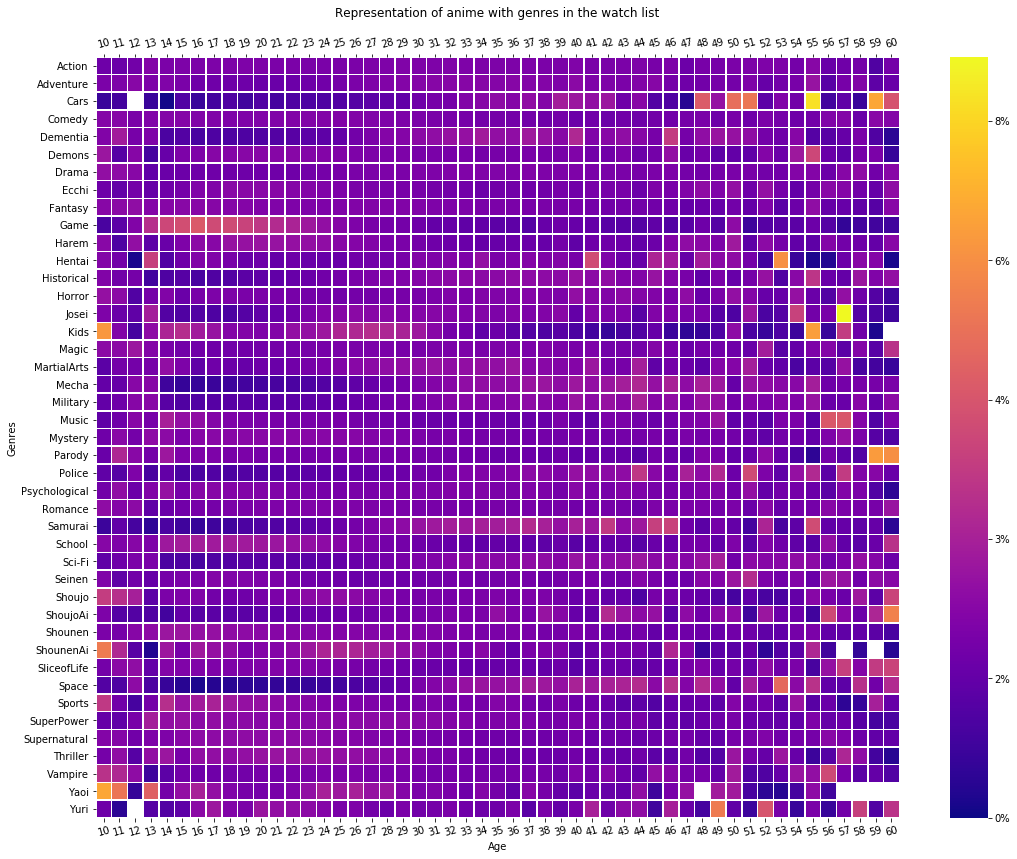

In [92]:
f, ax = plt.subplots(figsize=(18, 14))
renaming = {x: x.replace('completed_', '') for x in completed_columns}
data = ages_genres.div(ages_genres.sum(axis=0), axis=1) * 100
data = data.rename(columns=renaming)
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres == 0] = True
sns.heatmap(data.T, mask=mask.T, cmap=plt.cm.plasma, linewidths=.5, cbar_kws={'format': '%.0f%%'})
plt.gca().tick_params(labelbottom=True,labeltop=True, top=True, bottom=True)
plt.title('Representation of anime with genres in the watch list', pad=40)
plt.xticks(rotation=15)
plt.xlabel('Age')
plt.ylabel('Genres')